## Light Curve Analysis 

WASP74b
- https://arxiv.org/pdf/1410.6358v2.pdf
- http://exoplanet.eu/catalog/wasp-74_b/

hanya linear

In [1]:
import math as mt
from numpy import *
import matplotlib.pyplot as plt

from os.path import join

from pytransit.orbits_f import orbits as of
from pytransit import MandelAgol as MA

from exotk.de import DiffEvol
from exotk.priors import PriorSet, UP, NP, JP
from exotk.utils.orbits import as_from_rhop
from exotk.utils.likelihood import ll_normal_es

from emcee import EnsembleSampler
from emcee import autocorr

%matplotlib inline

### Read the transit data

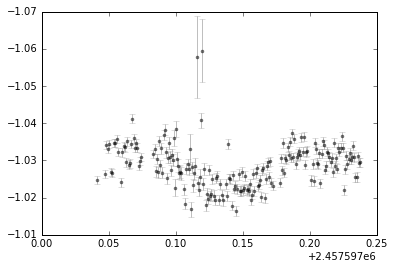

In [2]:
data = genfromtxt("../data/wasp-74b_star_5_curve_R_1.txt", names=['jd', 'dm', 'xx', 'yy', 'zz'])
plt.errorbar(data['jd'], data['dm'], yerr=data['xx'], fmt='k.', ecolor='grey', alpha=0.5)
plt.gca().invert_yaxis()
plt.show()

### Subjectively remove bad data

We can include bad data in bayesian analysis, but we have to change likelihood function. Computation's cost will be high.

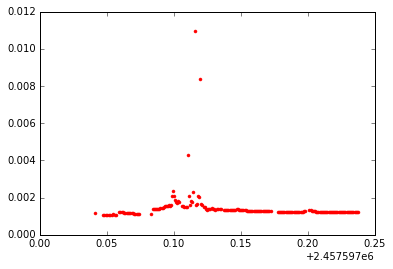

In [3]:
plt.plot(data['jd'], data['xx'], 'r.') # error

Remove data which has large error

In [4]:
t = data['jd'][data['xx'] < 0.002]
dm = data['dm'][data['xx'] < 0.002]
err = data['xx'][data['xx'] < 0.002]

In [5]:
print t.min(), t.max()

2457597.04104 2457597.23741


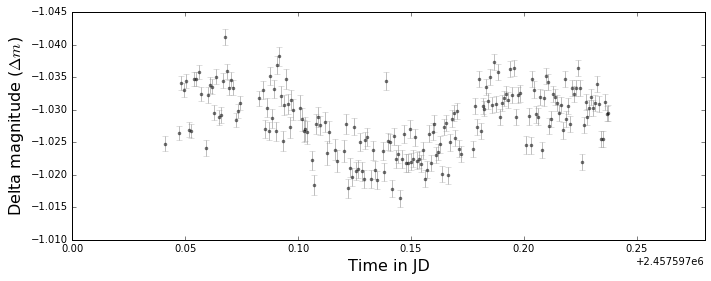

In [6]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
ax.errorbar(t, dm, yerr=err, fmt='k.', ecolor='grey', alpha=0.5)
ax.set_xlabel("Time in JD", fontsize=16)
ax.set_ylabel(r"Delta magnitude ($\Delta m$)", fontsize=16)
#ax.autoscale(enable=False)
ax.set_xlim([2457597.0, 2457597.28])
ax.set_ylim([-1.045, -1.010])
ax.invert_yaxis()
plt.tight_layout()

Remove some data in the most left and right

In [7]:
t = t[6:172]
dm = dm[6:172]
err = err[6:172]

<Container object of 3 artists>

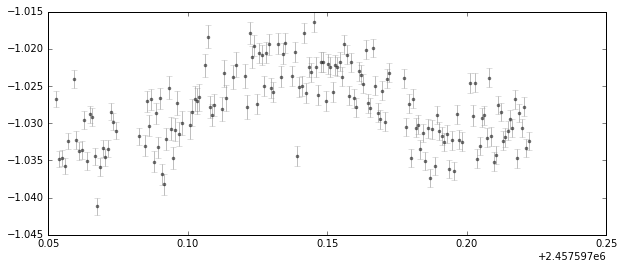

In [8]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
ax.errorbar(t, dm, yerr=err, fmt='k.', ecolor='grey', alpha=0.5)

<Container object of 3 artists>

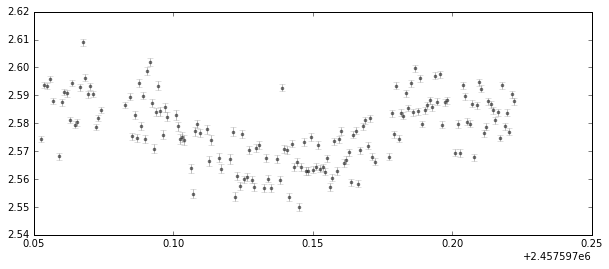

In [9]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
ax.errorbar(t, 10**(dm/(-2.5)), yerr=err, fmt='k.', ecolor='grey', alpha=0.5)

### Log Posterior Function

We want to include detrending process in this analysis.

Function that we want to fit:

$$\Delta m = A - 2.5\log(F_{ratio}) + B(t-\bar{t}) + C(t-\bar{t})^2$$

In [10]:
class LPFunction(object):
    """A simple log posterior function class.
    """
    def __init__(self, time, dm, nthreads=2):
        # time, magnitude
        self.tm = MA(lerp=True, klims=(0.08,0.13), nthr=nthreads) 
        self.nthr = nthreads

        self.time     = time.copy()
        self.dm_o   = dm.copy()
        self.npt      = dm.size
        self.meant    = mean(self.time)
        self.timeshift = self.time - self.meant
#         self._wrk_lc  = zeros_like(time)  # These two work arrays are actually rather pointless
        self._wrk_ld  = zeros(2)          #
        
        self.priors = [NP(2457597.13, 0.03,  'tc'), ##  0  - Transit centre
                       NP(2.13775,  0.02,   'p'),   ##  1  - Period
                       JP( 0.007,  0.0125,  'k2'),  ##  2  - planet-star area ratio
                       NP(   0.5,    0.05, 'rho'),  ##  3  - Stellar density in gr/cm^3
                       UP(     0,   0.99,   'b'),   ##  4  - Impact parameter
                       UP( 0.002,   0.02,   'e'),   ##  5  - White noise std
                       UP(     0,    1.0,  'q1'),   ##  6  - limb darkening q1
                       UP(     0,    1.0,  'q2'),   ##  7  - limb darkening q2
                       UP(   -1.53,   -0.53,   'A'),   ##  8  - constant
                       UP(   -2.0E-2,   2.0E-2,   'B')]#,   ##  9  - linear constant
                       #UP(   -5.0E-3,   5.0E-3,   'C')]   ##  10 - quadratic constant
        
        
        self.ps = PriorSet(self.priors)
        
#     def compute_baseline(self, pv):
#         """Simple constant baseline model"""
#         self._wrk_lc.fill(pv[6])
#         return self._wrk_lc

    
    def compute_transit(self, pv):
        """Transit model"""
        _a  = as_from_rhop(pv[3], pv[1])  # Scaled semi-major axis from stellar density and orbital period
        _i  = mt.acos(pv[4]/_a)           # Inclination from impact parameter and semi-major axis
        _k  = mt.sqrt(pv[2])              # Radius ratio from area ratio
        
        a, b = mt.sqrt(pv[6]), 2*pv[7]
        self._wrk_ld[:] = a*b, a*(1.-b)   # Quadratic limb darkening coefficients
        
        return self.tm.evaluate(self.time, _k, self._wrk_ld, pv[0], pv[1], _a, _i)

    
    def compute_lc_model(self, pv):
        """Combined baseline and transit model"""
        """in magnitude"""
        return pv[8] - 2.5*log10(self.compute_transit(pv)) + \
                pv[9]*self.timeshift# + pv[10]*self.timeshift*self.timeshift


    def __call__(self, pv):
        """Log posterior density"""
        if any(pv < self.ps.pmins) or any(pv > self.ps.pmaxs):
            return -inf
        
        dm_m = self.compute_lc_model(pv)
        return self.ps.c_log_prior(pv) + ll_normal_es(self.dm_o, dm_m, pv[5])

### Basic parameter estimation

Generate parameter vector population clumped around the posterior maxima using Differential Evolution

In [11]:
npop, de_iter, mc_iter = 100, 100, 10000 # nwalkers, de_iteration_number, mcmc_iteration

lpf = LPFunction(t, dm)

de = DiffEvol(lpf, lpf.ps.bounds, npop, maximize=True)

In [12]:
npar = lpf.ps.ndim

In [13]:
de.optimize(de_iter)

(array([  2.45759714e+06,   2.12826097e+00,   9.40410362e-03,
          4.74090282e-01,   8.50019217e-01,   3.31832578e-03,
          3.86737408e-01,   7.40224419e-01,  -1.03147751e+00,
          8.39767742e-03]), -734.2919549304047)

In [14]:
print lpf.ps.bounds

[[  2.45759698e+06   2.45759728e+06]
 [  2.03775000e+00   2.23775000e+00]
 [  7.00000000e-03   1.25000000e-02]
 [  2.50000000e-01   7.50000000e-01]
 [  0.00000000e+00   9.90000000e-01]
 [  2.00000000e-03   2.00000000e-02]
 [  0.00000000e+00   1.00000000e+00]
 [  0.00000000e+00   1.00000000e+00]
 [ -1.53000000e+00  -5.30000000e-01]
 [ -2.00000000e-02   2.00000000e-02]]


### Run MCMC

In [15]:
sampler = EnsembleSampler(npop, lpf.ps.ndim, lpf) # init sampler (nwalkers, ndim, lnprob posterior)

In [16]:
sampler.run_mcmc(de.population, mc_iter); # run mcmc (starting guess, number of step)

#### Overview

The MCMC chains are now stored in sampler.chain. Let's first have a look into how the chain populations evolved to see if we have any problems with our setup, whether we have converged to sample the true posterior distribution, and, if so, what was the burn-in time.

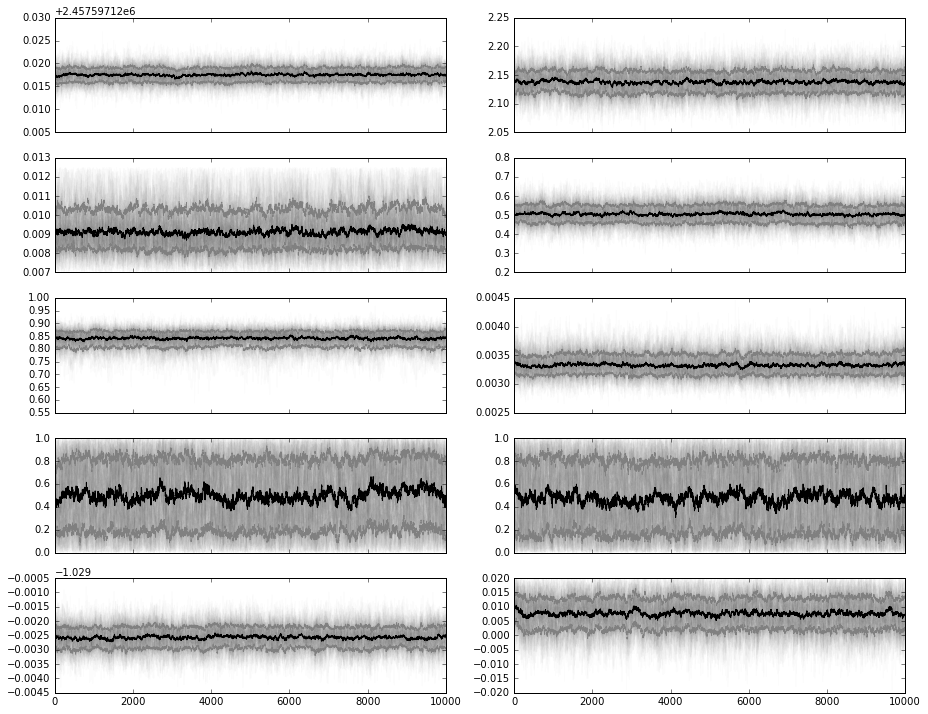

In [17]:
fig, axs = plt.subplots(5,2, figsize=(13,10), sharex=True)
ls, lc = ['-','--','--'], ['k', '0.5', '0.5']
percs = [percentile(sampler.chain[:,:,i], [50,16,84], 0) for i in range(npar)]
[axs.flat[i].plot(sampler.chain[:,:,i].T, 'k', alpha=0.01) for i in range(npar)]
[[axs.flat[i].plot(percs[i][j], c=lc[j], ls=ls[j]) for j in range(3)] for i in range(npar)]
fig.tight_layout()

Good, they don't show any significant long-term trends. We can decide a suitable *burning factor* (due to initial guess).

Look the mean autocorrelation length for each parameter in order to decide a suitable MCMC chain *thinning factor* (because the consecutive MCMC samples are correlated)

In [18]:
sampler.chain.shape
autocor = autocorr.integrated_time(sampler.chain.reshape((-1, lpf.ps.ndim)), c=10, axis=0)
print autocor
print 'mean = ', int(mean(autocor))

[ 186.20133829  181.01460254  190.10441319  192.64360605  238.36091635
  160.93942523  245.7937895   208.26727038  182.84751603  140.08492336]
mean =  192


#### Burn-it all baby

In [19]:
burn = 2000
thin = int(mean(autocor))
walkers = sampler.chain[:, burn::thin, :]
samples = walkers.reshape((-1, lpf.ps.ndim)) #nsamples, n_parameter

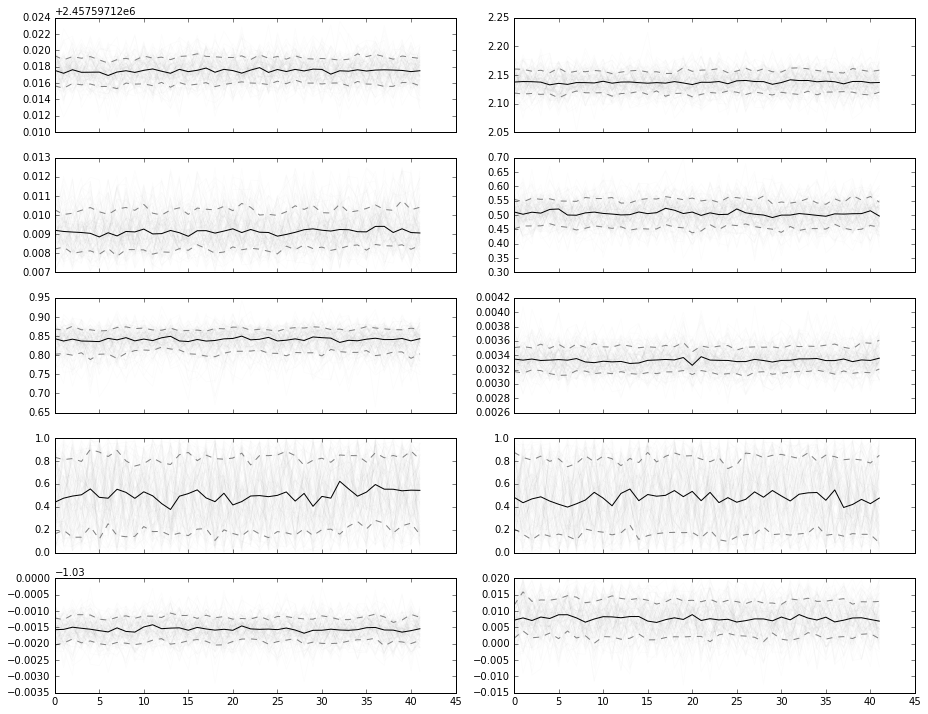

In [20]:
fig, axs = plt.subplots(5,2, figsize=(13,10), sharex=True)
ls, lc = ['-','--','--'], ['k', '0.5', '0.5']
percs = [percentile(walkers[:,:,i], [50,16,84], 0) for i in range(npar)]
[axs.flat[i].plot(walkers[:,:,i].T, 'k', alpha=0.01) for i in range(npar)]
[[axs.flat[i].plot(percs[i][j], c=lc[j], ls=ls[j]) for j in range(3)] for i in range(npar)]
#setp(axs, yticks=[])
fig.tight_layout()

### Analysis the Result

In [21]:
import corner

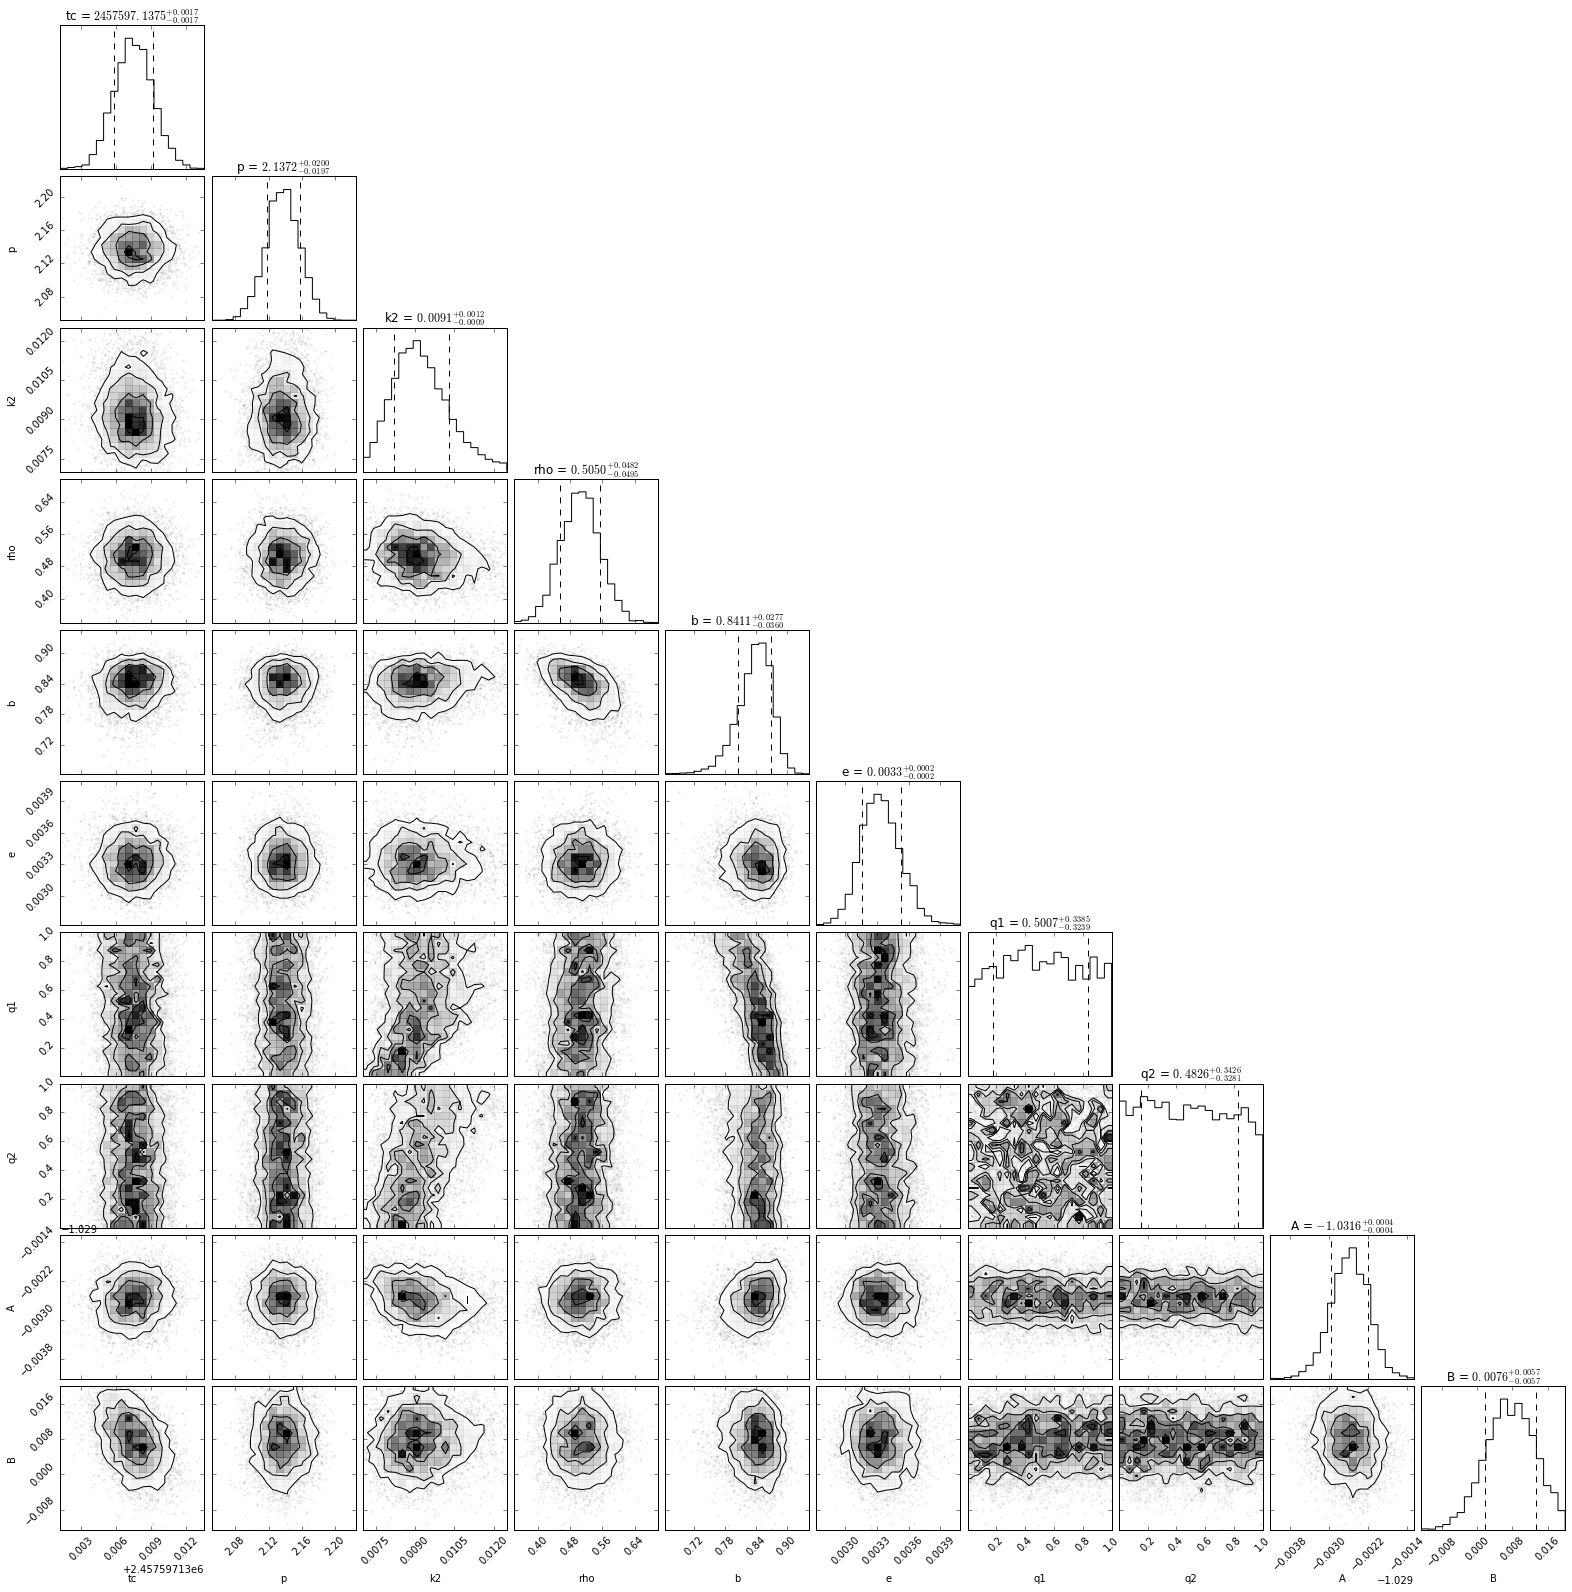

In [22]:
fig = corner.corner(samples, quantiles=(0.16, 0.84), show_titles=True, title_fmt='.4f', \
                    # truths=[params.t0, params.per, k2_true, density_true.value, b_true, std, 1.0, q1_true, q2_true], \
                    labels=lpf.ps.names, title_kwargs={"fontsize": 12})

#### Quantile of parameters, median $\pm '1 \sigma'$

In [23]:
pars = lpf.ps.names
theta = zeros(npar*3).reshape((npar,3)) 
for i in range(npar):
    theta[i,:] = corner.quantile(samples[:,i], [0.16, 0.5, 0.84]) # median = theta[:,1]
    print pars[i], "\t = ", theta[i,1], "\t +- ", [theta[i,2]-theta[i,1], theta[i,0]-theta[i,1]]

tc 	 =  2457597.13749 	 +-  [0.0016644755378365517, -0.0016521918587386608]
p 	 =  2.1372134242 	 +-  [0.020014964464355245, -0.019696296748163089]
k2 	 =  0.00912739530289 	 +-  [0.0011783957766566336, -0.00094269000138559253]
rho 	 =  0.505041107484 	 +-  [0.048223898988705383, -0.049502541446640236]
b 	 =  0.841145518266 	 +-  [0.027654063981390364, -0.036005851659914101]
e 	 =  0.00332905005767 	 +-  [0.00019366884297603981, -0.00017382808736269087]
q1 	 =  0.500677936753 	 +-  [0.33849452542817504, -0.32389238973110723]
q2 	 =  0.482625228904 	 +-  [0.34256151886080377, -0.32807001898843213]
A 	 =  -1.03156609473 	 +-  [0.00037278800144813218, -0.00038629802079848119]
B 	 =  0.00759283463532 	 +-  [0.0056820315388313803, -0.0057209332722998685]


In [24]:
# radius ratio
radius_ratio = sqrt(samples[:,2])
kk = corner.quantile(radius_ratio, [0.16, 0.5, 0.84])
print "radius ratio = ", kk[1], "+-", [kk[2]-kk[1], kk[0]-kk[1]]

# scaled semimajor axis
_a = as_from_rhop(samples[:,3], samples[:,1])
kk = corner.quantile(_a, [0.16, 0.5, 0.84])
print "scaled semimajor axis = ", kk[1], "+-", [kk[2]-kk[1], kk[0]-kk[1]]

# inclination
TORAD = 180./pi
inc = arccos(samples[:,4]/_a) * TORAD
ii = corner.quantile(inc, [0.16, 0.5, 0.84])
print "inclination = ", ii[1], "+-", [ii[2]-ii[1], ii[0]-ii[1]]

# limb darkening coeffs
u = 2*sqrt(samples[:,6])*samples[:,7]
v = sqrt(samples[:,6])*(1. - 2*samples[:,7])
uu = corner.quantile(u, [0.16, 0.5, 0.84])
vv = corner.quantile(v, [0.16, 0.5, 0.84])
print "u = ", uu[1], "+-", [uu[2]-uu[1], uu[0]-uu[1]]
print "v = ", vv[1], "+-", [vv[2]-vv[1], vv[0]-vv[1]]

radius ratio =  0.0955374025678 +- [0.0059800396520940102, -0.0050680414648993505]
scaled semimajor axis =  4.96073142596 +- [0.15495884290770068, -0.17873831960767639]
inclination =  80.2485249727 +- [0.60267092946514822, -0.61165866541364267]
u =  0.58539061467 +- [0.56022983982016095, -0.41757892387859008]
v =  0.0165861581751 +- [0.43529838478156224, -0.42687075273206532]


In [25]:
mp = theta[:,1] # median of parameters

In [26]:
print mp

[  2.45759714e+06   2.13721342e+00   9.12739530e-03   5.05041107e-01
   8.41145518e-01   3.32905006e-03   5.00677937e-01   4.82625229e-01
  -1.03156609e+00   7.59283464e-03]


In [27]:
# compute the light curve using first 1000 derived parameters
flux_pr = array([lpf.compute_lc_model(pv) for pv in samples[random.permutation(samples.shape[0])[:1000]]]) 

# flux percentile
flux_pc = array(percentile(flux_pr, [50, 0.15, 99.85, 2.5, 97.5, 16, 84], 0))

### Overplot the result with data

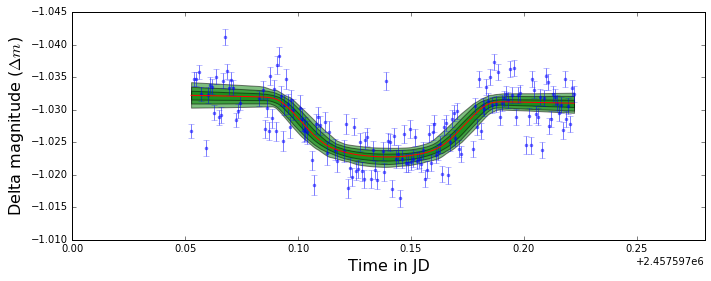

In [28]:
zx1,zx2,zy1,zy2 = 0.95, 0.965, 0.985, 0.99
fig, ax = plt.subplots(1,1, figsize=(10,4))

# data with errorbar from calculation
ax.errorbar(lpf.time, lpf.dm_o, err, fmt='.', c='b', alpha=0.5) 

# combination from other percentile
[ax.fill_between(lpf.time,*flux_pc[i:i+2,:], alpha=0.5, facecolor='g') for i in range(1,6,2)] 

# median (center line)
ax.plot(lpf.time, flux_pc[0], c='r') 

#setp(ax, xlim=lpf.time[[0,-1]], xlabel='Time', ylabel='Normalized flux')

ax.set_xlabel("Time in JD", fontsize=16)
ax.set_ylabel(r"Delta magnitude ($\Delta m$)", fontsize=16)
ax.set_xlim([2457597.0, 2457597.28])
ax.set_ylim([-1.045, -1.010])

ax.invert_yaxis()
fig.tight_layout()

### Removed trend

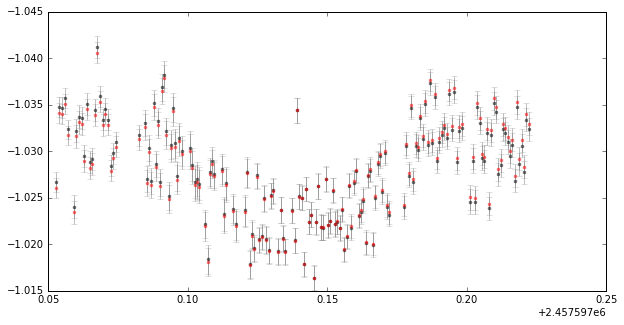

In [30]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.errorbar(lpf.time, lpf.dm_o, yerr=err, fmt='k.', ecolor='grey', alpha=0.5)
ax.errorbar(lpf.time, lpf.dm_o - mp[9]*lpf.timeshift, yerr=err, fmt='r.', ecolor='grey', alpha=0.5)
ax.invert_yaxis()

### Check correlation plot of some parameters

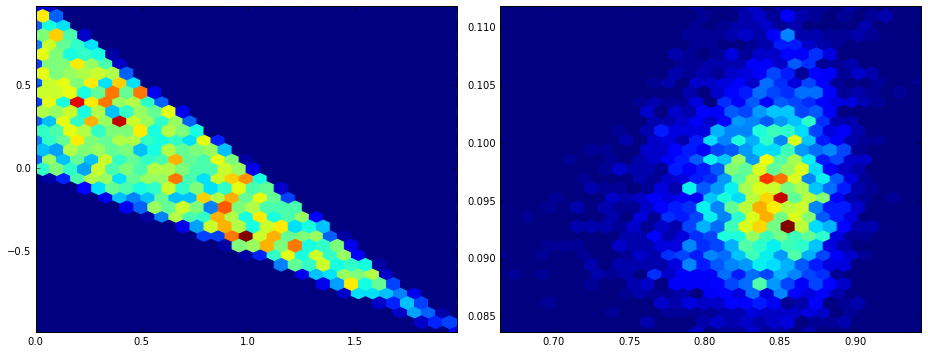

In [31]:
fig, axs = plt.subplots(1,2, figsize=(13,5))
cpars = dict(gridsize=30)
axs[0].hexbin(u,v, **cpars)
axs[1].hexbin(samples[:,4],radius_ratio, **cpars)
fig.tight_layout()

Calculate R planet using mass of the star

In [32]:
Mstar = 1.48
sigmaMstar = 0.12

In [33]:
N = len(samples[:,2])
print N

4200


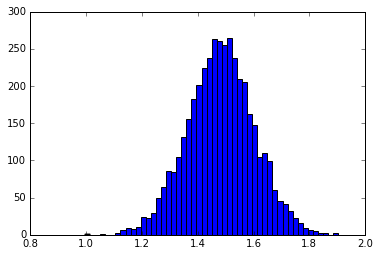

In [34]:
Ms = random.normal(Mstar, sigmaMstar, N)
plt.hist(Ms, bins=50);

In [35]:
Vol = Ms*2e30/(samples[:,3]*1000) # M/rho

In [36]:
rstar = (3.*Vol/(4*pi))**(1/3.)

In [37]:
rp_km = sqrt(samples[:,2])*rstar/1000

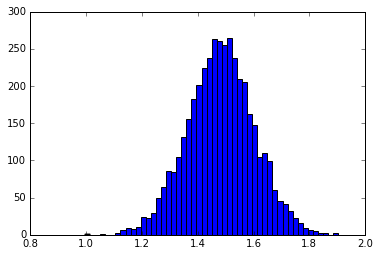

In [38]:
rp_jupiter = rp_km/69911.
plt.hist(Ms, bins=50);

In [39]:
rpj = corner.quantile(rp_jupiter, [0.16, 0.5, 0.84])
print "radius of planet in jup radius", rpj[1], "+-", [rpj[2]-rpj[1], rpj[0]-rpj[1]]

radius of planet in jup radius 1.52895082342 +- [0.12720011162385458, -0.10698073301367561]
